In [4]:
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import cv2
import imutils
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
#initialize needed functions

class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)

        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"

        # return the name of the shape
        return shape
    
    
def find_min_max_xcoord(vertices): 
    """
    Given a list of vertices for a contour, 
    return the min & max x-coordinate of the object and the width of the object in pixels
    """
    _first_pass = True
    
    for _v in vertices:
        
        _current_x = _v[0][0]
        
        if _first_pass == True:
            # initialize min and max x
            _min_x = _current_x
            _max_x = _min_x
            _first_pass = False
        else:
            if _current_x < _min_x:
                _min_x = _current_x
                
            if _current_x > _max_x:
                _max_x = _current_x
    
    _width_of_object = _max_x-_min_x
    
    return (_min_x, _max_x, _width_of_object)
def interpolate_distance_from_object(width):
    """
    Given a width in pixels
    Return the approximate distance from the camera's perspective
    """
    # You can tune it to a specific camera/environment
    # Set up the measured object and its distance as reference for extrapolation
    
    # The first is the reference point a near object
    #    For example, a 600 pixel wide circle is at 10 cm from the camera
    _MAX_WIDTH = 600
    _DIST_FOR_MAX_WIDTH_OBJECT = 10

    # The second is the reference point of a far away object
    #    For example, a 50 pixel wide circle is at 600 cm from the camera
    _MIN_WIDTH = 50
    _DIST_FOR_MIN_WIDTH_OBJECT = 600
    
    # If the object is wider than our _MAX_WIDTH measurement
    # we'll just say it as far as the closest object
    if width > _MAX_WIDTH:
        _approximate_distance = _DIST_FOR_MAX_WIDTH_OBJECT
        
    elif width < _MIN_WIDTH:
        # If width is smaller than our smallest measurement
        # we'll say it is as far as the farthest object
        _approximate_distance = _DIST_FOR_MIN_WIDTH_OBJECT
    
    else:
        # Solving the equation for y = mx + b
        #   m = _slope
        #   b = _constant
        _slope = (_DIST_FOR_MAX_WIDTH_OBJECT - _DIST_FOR_MIN_WIDTH_OBJECT)/(_MAX_WIDTH - _MIN_WIDTH)
        _constant = _DIST_FOR_MIN_WIDTH_OBJECT - _slope * _MIN_WIDTH
    
        # Now, we interapolate the distance from our actual measurements in cm
        _approximate_distance = round(_slope * width + _constant, 2)
    
    return _approximate_distance

def angle_from_center(image, point_of_interest, debug=False):
    """
    This takes a color image and a point (x, y) with the image
    and return the angle in degrees from the perspective of the camera
    from the middle bottom (width/2, height) coordinate of the image
    """
    
    # Find the camera's coordinates
    (_height, _width, _depth) = image.shape
    _x_camera = int(_width / 2)
    _y_camera = _height
    
    (_x1, _y1) = point_of_interest
    
    
    _adjacent_distance = _y_camera - _y1
    _opposite_distance = _x1 - _x_camera
    
    if debug:
        print("camera coordinates (%i, %i)" % (_x_camera, _y_camera))
        print("POI    coordinates (%i, %i)" % (_x1, _y1))
        print("opposite distance %i and adjacent distance %i "%(_opposite_distance, _adjacent_distance))
    
    if _adjacent_distance != 0:
        # POI is not on the same y-axis as the camera
        angle_radian = math.atan(_opposite_distance / _adjacent_distance)
        degree = round((angle_radian*180)/math.pi, 1)
        
    elif _opposite_distance > 0:
        # POI is on the same y-axis and to the right of center point
        degree = 90.0
    else:
        # POI is on the same y-axis and to the left of center point
        degree = -90.0
        
    return degree

In [17]:
class ball:
    def __init__(self, dist, angle=0, contour=[[0,0]], center=(0,0)):
        self.dist, self.angle, self.contour, self.cX, self.cY = dist, angle, contour, center[0], center[1]

def find_closest_distance(image, lower_color_hsv, upper_color_hsv, min_area_size, 
                  kernel=3, output_text=True, print_centroids=True):
    closestBall = ball(image.shape[0], image.shape[1])
    """
    This takes in a color image, a lower HSV color and an upper HSV color range
    and a minimum pixel area size to detect a circle
    """
    _image = image.copy()
    
    # Blur and convert image to HSV
    _blur_img = cv2.GaussianBlur(_image, (kernel,kernel), 0)
    _hsv_img  = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    
    # Mask the image using the lower/upper hsv range
    _mask_img = cv2.inRange(_hsv_img, lower_color_hsv, upper_color_hsv)
    
    # Find the contours
    _contours = cv2.findContours(_mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _contours = imutils.grab_contours(_contours)
   
    # Initialize ShapeDetector
    _sd = ShapeDetector()
       
    for _c in _contours:
        _M = cv2.moments(_c)
        _area = cv2.contourArea(_c)

        try:
            _cX = int((_M["m10"] / _M["m00"]))
            _cY = int((_M["m01"] / _M["m00"]))
        except:
            _cX = 0
            _cY = 0

        _shape = _sd.detect(_c)

        if (_shape == "circle") and (_area >= min_area_size):
            
            # Find the width of the object
            (_min_x, _max_x, _width) = find_min_max_xcoord(_c)
            
            # Find the distance of the object
            _approx_distance = interpolate_distance_from_object(_width)
            
            # Find the angle from the camera
            _poi_angle = angle_from_center(image, (_cX, _cY))
            
            closestBall = ball(_approx_distance, _poi_angle, _c) if _approx_distance < closestBall.dist else closestBall
            
            # Drawing each contour in green (0, 255, 0) on top of the original image
            cv2.drawContours(_image, [_c], -1, (0, 255, 0), 2)
            cv2.circle(_image,(_cX, _cY), 6, (255, 0, 0), -1)
            
            if output_text:
                # Display the text for the image shape
                _center = "(%i, %i)"%(_cX, _cY)
                cv2.putText(_image, _center, (_cX+10, _cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
            if print_centroids:
                print("shape:", _shape, " area: ", _area, "center: (", _cX,",", _cY,")")
                print("min x: %i, max x: %i, width: %i, distance: %i, angle: %i"%(_min_x, _max_x, _width, _approx_distance, _poi_angle))
                
    #prints closest balls approx angle and position in top left of image
    cv2.putText(_image, "Angle: %.1f degrees"%(closestBall.angle), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    cv2.putText(_image, "Distance : %.1f cm"%(closestBall.dist), (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    #makes the closest balls contour purple``
    cv2.drawContours(_image, [closestBall.contour], -1, (255, 0, 255), 5)
    
    return _image

shape: circle  area:  141170.5 center: ( 1265 , 889 )
min x: 1052, max x: 1478, width: 426, distance: 196, angle: 65
shape: circle  area:  39752.0 center: ( 354 , 420 )
min x: 243, max x: 465, width: 222, distance: 415, angle: -29
shape: circle  area:  10823.5 center: ( 966 , 79 )
min x: 906, max x: 1026, width: 120, distance: 524, angle: 11


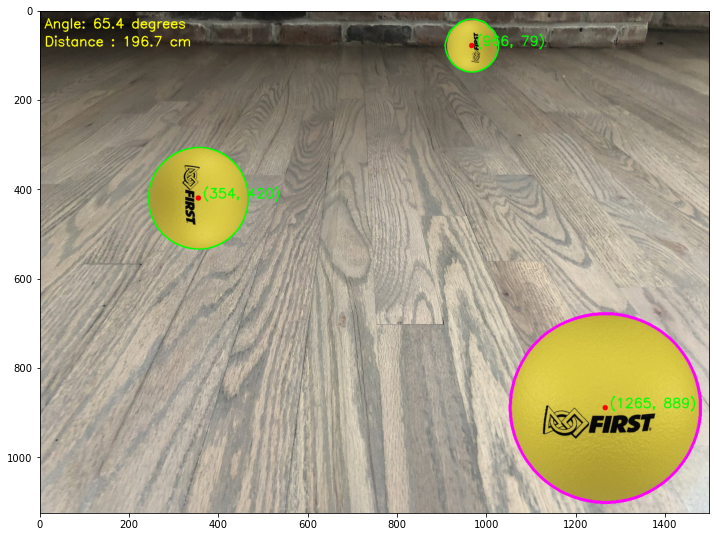

In [18]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_3balls.jpg')
ball_img = find_closest_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)